# Learning from samples

In [1]:
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_episode_driver, dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

from bellman.environments.environment_model import EnvironmentModel
from bellman.environments.tf_wrappers import TFTimeLimit
from bellman.environments.transition_model.keras_model.keras import (
    KerasTrainingSpec,
    KerasTransitionModel,
)
from bellman.environments.transition_model.keras_model.linear import LinearTransitionNetwork
from bellman.environments.transition_model.keras_model.trajectory_sampling import (
    InfiniteHorizonTrajectorySampling,
)
from examples.utils.classic_control import (
    MountainCarInitialState,
    MountainCarReward,
    MountainCarTermination,
)
from examples.utils.mountain_car import (
    plot_mountain_car_policy_decisions,
    plot_mountain_car_transitions,
)
from examples.utils.policies import sample_uniformly_distributed_observations_and_get_actions
from examples.utils.trajectories import sample_uniformly_distributed_transitions
from tests.tools.bellman.environments.reward_model import ConstantReward

"""
This notebook demonstrates how to assemble a batch model based reinforcement learning system. In
this example we generate trajectories from the Mountain Car gym environment using a random policy,
use that data to train a linear model of the transition function, and use sampled transitions from
the model to train a DQN agent.
"""


%matplotlib inline

This example is based on Mountain Car because it is straightforward to visualise the state space
and the linearised dynamics contain enough information to learn a controller using reinforcement
learning.

In [2]:
global_step = tf.compat.v1.train.get_or_create_global_step()
tf_env = TFPyEnvironment(suite_gym.load("MountainCar-v0"))

## Dynamics model

We define the linear model that is going to be used to model the transition function of this
environment. We plot the predicted dynamics of the untrained model. The action space of the
mountain car environment consists of three discrete elements. These are represented in all
subsequent plots with three colours:
- left impulse: blue
- no impule: red
- right impulse: green

In these state-space plots, the x-axis is the agents position and the y-axis is the velocity.

In [3]:
batch_size = 64

training_spec = KerasTrainingSpec(
    epochs=5000,
    training_batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)],
    verbose=0,
)
linear_transition_network = LinearTransitionNetwork(tf_env.observation_spec())
trajectory_sampling_strategy = InfiniteHorizonTrajectorySampling(batch_size, 1)
transition_model = KerasTransitionModel(
    [linear_transition_network],
    tf_env.observation_spec(),
    tf_env.action_spec(),
)
reward_model = ConstantReward(tf_env.observation_spec(), tf_env.action_spec())
sample_transitions = sample_uniformly_distributed_transitions(
    transition_model, 1000, reward_model
)

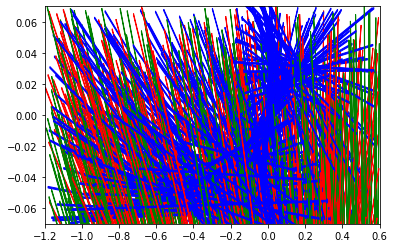

In [4]:
plot_mountain_car_transitions(
    sample_transitions.observation.numpy(),
    sample_transitions.action.numpy(),
    sample_transitions.next_observation.numpy(),
)

## TF-Agents Agent

In this notebook we train a TF-Agents DQN agent on samples from the dynamics model. The TF-Agents
agents define two policies: a collect policy and a training policy. For this DQN agent, the
training policy is a greedy policy parametrised by a Q value neural network, and the collect
policy is the associated epsilon greedy policy.

We use the collect policy from the untrained DQN agent to generate trajectories from the real
Mountain Car environment in order to train the dynamics model.

In [5]:
train_sequence_length = 1
fc_layer_params = (100,)
collect_model_training_episodes = 100
model_training_buffer_capacity = 25000
collect_steps_per_iteration = 10000
epsilon_greedy = 0.1
replay_buffer_capacity = 1000000
target_update_tau = 0.05
target_update_period = 5
learning_rate = 1e-3
n_step_update = 1
gamma = 0.99
gradient_clipping = None
reward_scale_factor = 1.0
debug_summaries = False
summarize_grads_and_vars = False

q_net = q_network.QNetwork(
    tf_env.observation_spec(), tf_env.action_spec(), fc_layer_params=fc_layer_params
)


tf_agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    epsilon_greedy=epsilon_greedy,
    n_step_update=n_step_update,
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step,
)
tf_agent.initialize()


eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

model_training_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    collect_policy.trajectory_spec,
    batch_size=tf_env.batch_size,
    max_length=model_training_buffer_capacity,
)

model_collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env,
    collect_policy,
    observers=[model_training_buffer.add_batch],
    num_episodes=collect_model_training_episodes,
)

model_collect_driver.run()


def train_model_step():
    trajectories = model_training_buffer.gather_all()
    return transition_model.train(trajectories, training_spec)


train_model_step()

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


This plot was produced in the same manner as the previous one, but the model has now been trained on
data from the real environment. The dynamics of the environment have been captured by the model.

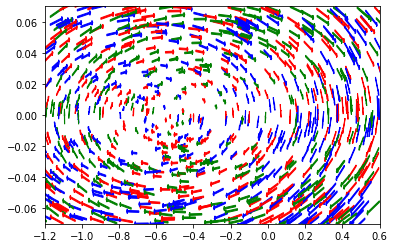

In [6]:
sample_transitions = sample_uniformly_distributed_transitions(
    transition_model, 1000, reward_model
)

plot_mountain_car_transitions(
    sample_transitions.observation.numpy(),
    sample_transitions.action.numpy(),
    sample_transitions.next_observation.numpy(),
)

## Training on samples

We define an environment which uses the trained transition model for the dynamics, along with a
reward function, episode termination condition, initial state distributions and bound on episode
length.

In [7]:
reward = MountainCarReward(tf_env.observation_spec(), tf_env.action_spec())
terminates = MountainCarTermination(tf_env.observation_spec())
initial_state_distribution = MountainCarInitialState(tf_env.observation_spec())
environment_model = TFTimeLimit(
    EnvironmentModel(transition_model, reward, terminates, initial_state_distribution),
    duration=200,
)

The agent is trained on data gathered from the environment model. Using the environment interface
means the TF-Agents drivers can be used to generate rollouts.

In [8]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity,
)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    environment_model,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration,
)

Before training the policy we plot the decisions made at random locations in the state space.

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


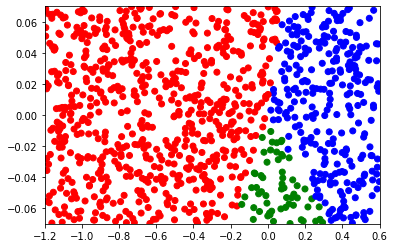

In [9]:
time_step = None
policy_state = collect_policy.get_initial_state(tf_env.batch_size)
collect_driver.run(time_step=time_step, policy_state=policy_state)

sample_trajectories = replay_buffer.gather_all()

samples = sample_uniformly_distributed_observations_and_get_actions(tf_agent.policy, 1000)
plot_mountain_car_policy_decisions(samples["observations"].numpy(), samples["actions"].numpy())

After a single training iteration, we again plot the decisions made by the policy.

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


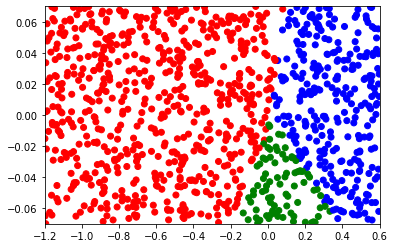

In [10]:
def train_step():
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, sample_batch_size=batch_size, num_steps=train_sequence_length + 1
    ).prefetch(3)
    iterator = iter(dataset)
    experience, _ = next(iterator)
    return tf_agent.train(experience)


time_step, policy_state = collect_driver.run(time_step=time_step, policy_state=policy_state)
train_loss = train_step()

samples = sample_uniformly_distributed_observations_and_get_actions(tf_agent.policy, 1000)
plot_mountain_car_policy_decisions(samples["observations"].numpy(), samples["actions"].numpy())

Having trained the policy for a small number of iterations it is clear that the policy is
improving. 

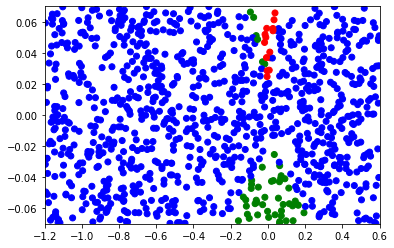

In [11]:
for _ in range(5):
    time_step, policy_state = collect_driver.run(
        time_step=time_step, policy_state=policy_state
    )
    train_loss = train_step()

samples = sample_uniformly_distributed_observations_and_get_actions(tf_agent.policy, 1000)
plot_mountain_car_policy_decisions(samples["observations"].numpy(), samples["actions"].numpy())